# Import libraries

In [ ]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Machine Learning / Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Data Splitting
from sklearn.model_selection import train_test_split

# Load the dataset

In [2]:
import os
import pandas as pd

train_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# --- Build dataframe for Train ---
train_data = []
for label, directory in enumerate(os.listdir(train_dir)):
    dir_path = os.path.join(train_dir, directory)
    if os.path.isdir(dir_path):  # ensure it's a folder
        for filename in os.listdir(dir_path):
            image_path = os.path.join(dir_path, filename)
            train_data.append({'image_path': image_path, 'label': label})

train_df = pd.DataFrame(train_data)

test_data = []
for label, directory in enumerate(os.listdir(test_dir)):
    dir_path = os.path.join(test_dir, directory)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            image_path = os.path.join(dir_path, filename)
            test_data.append({'image_path': image_path, 'label': label})

test_df = pd.DataFrame(test_data)

# --- Combine ---
df = pd.concat([train_df, test_df], ignore_index=True)
del train_df, test_df

# Show summary
print("Total images:", len(df))
print(df.head())

Total images: 2357
                                          image_path  label
0  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0
1  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0
2  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0
3  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0
4  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0


 This set consists of 2357 images of malignant and benign oncological diseases, which were formed from The International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

    actinic keratosis
    basal cell carcinoma
    dermatofibroma
    melanoma
    nevus
    pigmented benign keratosis
    -seborrheic keratosis
    squamous cell carcinoma
    vascular lesion


In [3]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'pigmented benign keratosis',
 1: 'melanoma',
 2: 'vascular lesion',
 3: 'actinic keratosis',
 4: 'squamous cell carcinoma',
 5: 'basal cell carcinoma',
 6: 'seborrheic keratosis',
 7: 'dermatofibroma',
 8: 'nevus'}

In [4]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     478       
1               melanoma                       454       
2               vascular lesion                142       
3               actinic keratosis              130       
4               squamous cell carcinoma        197       
5               basal cell carcinoma           392       
6               seborrheic keratosis           80        
7               dermatofibroma                 111       
8               nevus                          373       
------------------------------------------------------------
Total                                         2357      


In [ ]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

# Checking the GPU configurations

In [6]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

4

In [8]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

# Exploratory Data Analysis

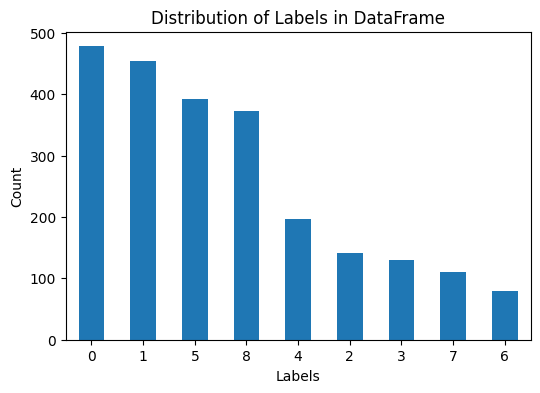

In [9]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

plt.figure(figsize=(6,4))
label_counts.plot(kind='bar')

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in DataFrame')
plt.xticks(rotation=0)
plt.show()

The dataset is imbalanced with class 0:pigmented benign keratosis having more images and 6: seborrheic keratosis having the least number of images.

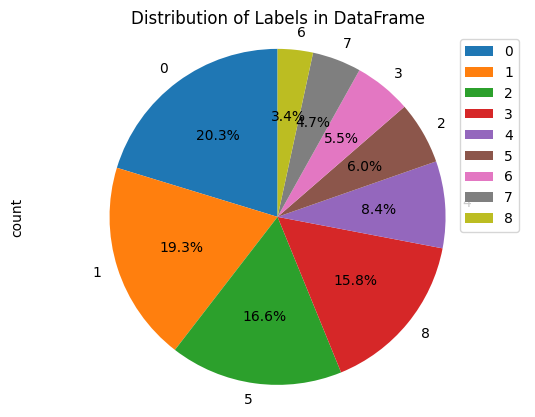

In [10]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [11]:
df.head()

image_path  label  \
0  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0   
1  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0   
2  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0   
3  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0   
4  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0   

                                               image  
0  [[[152, 131, 151], [153, 131, 151], [150, 128,...  
1  [[[170, 137, 151], [172, 140, 156], [170, 138,...  
2  [[[247, 170, 159], [247, 169, 159], [244, 166,...  
3  [[[174, 143, 162], [173, 142, 162], [171, 138,...  
4  [[[144, 124, 134], [147, 127, 138], [151, 131,...

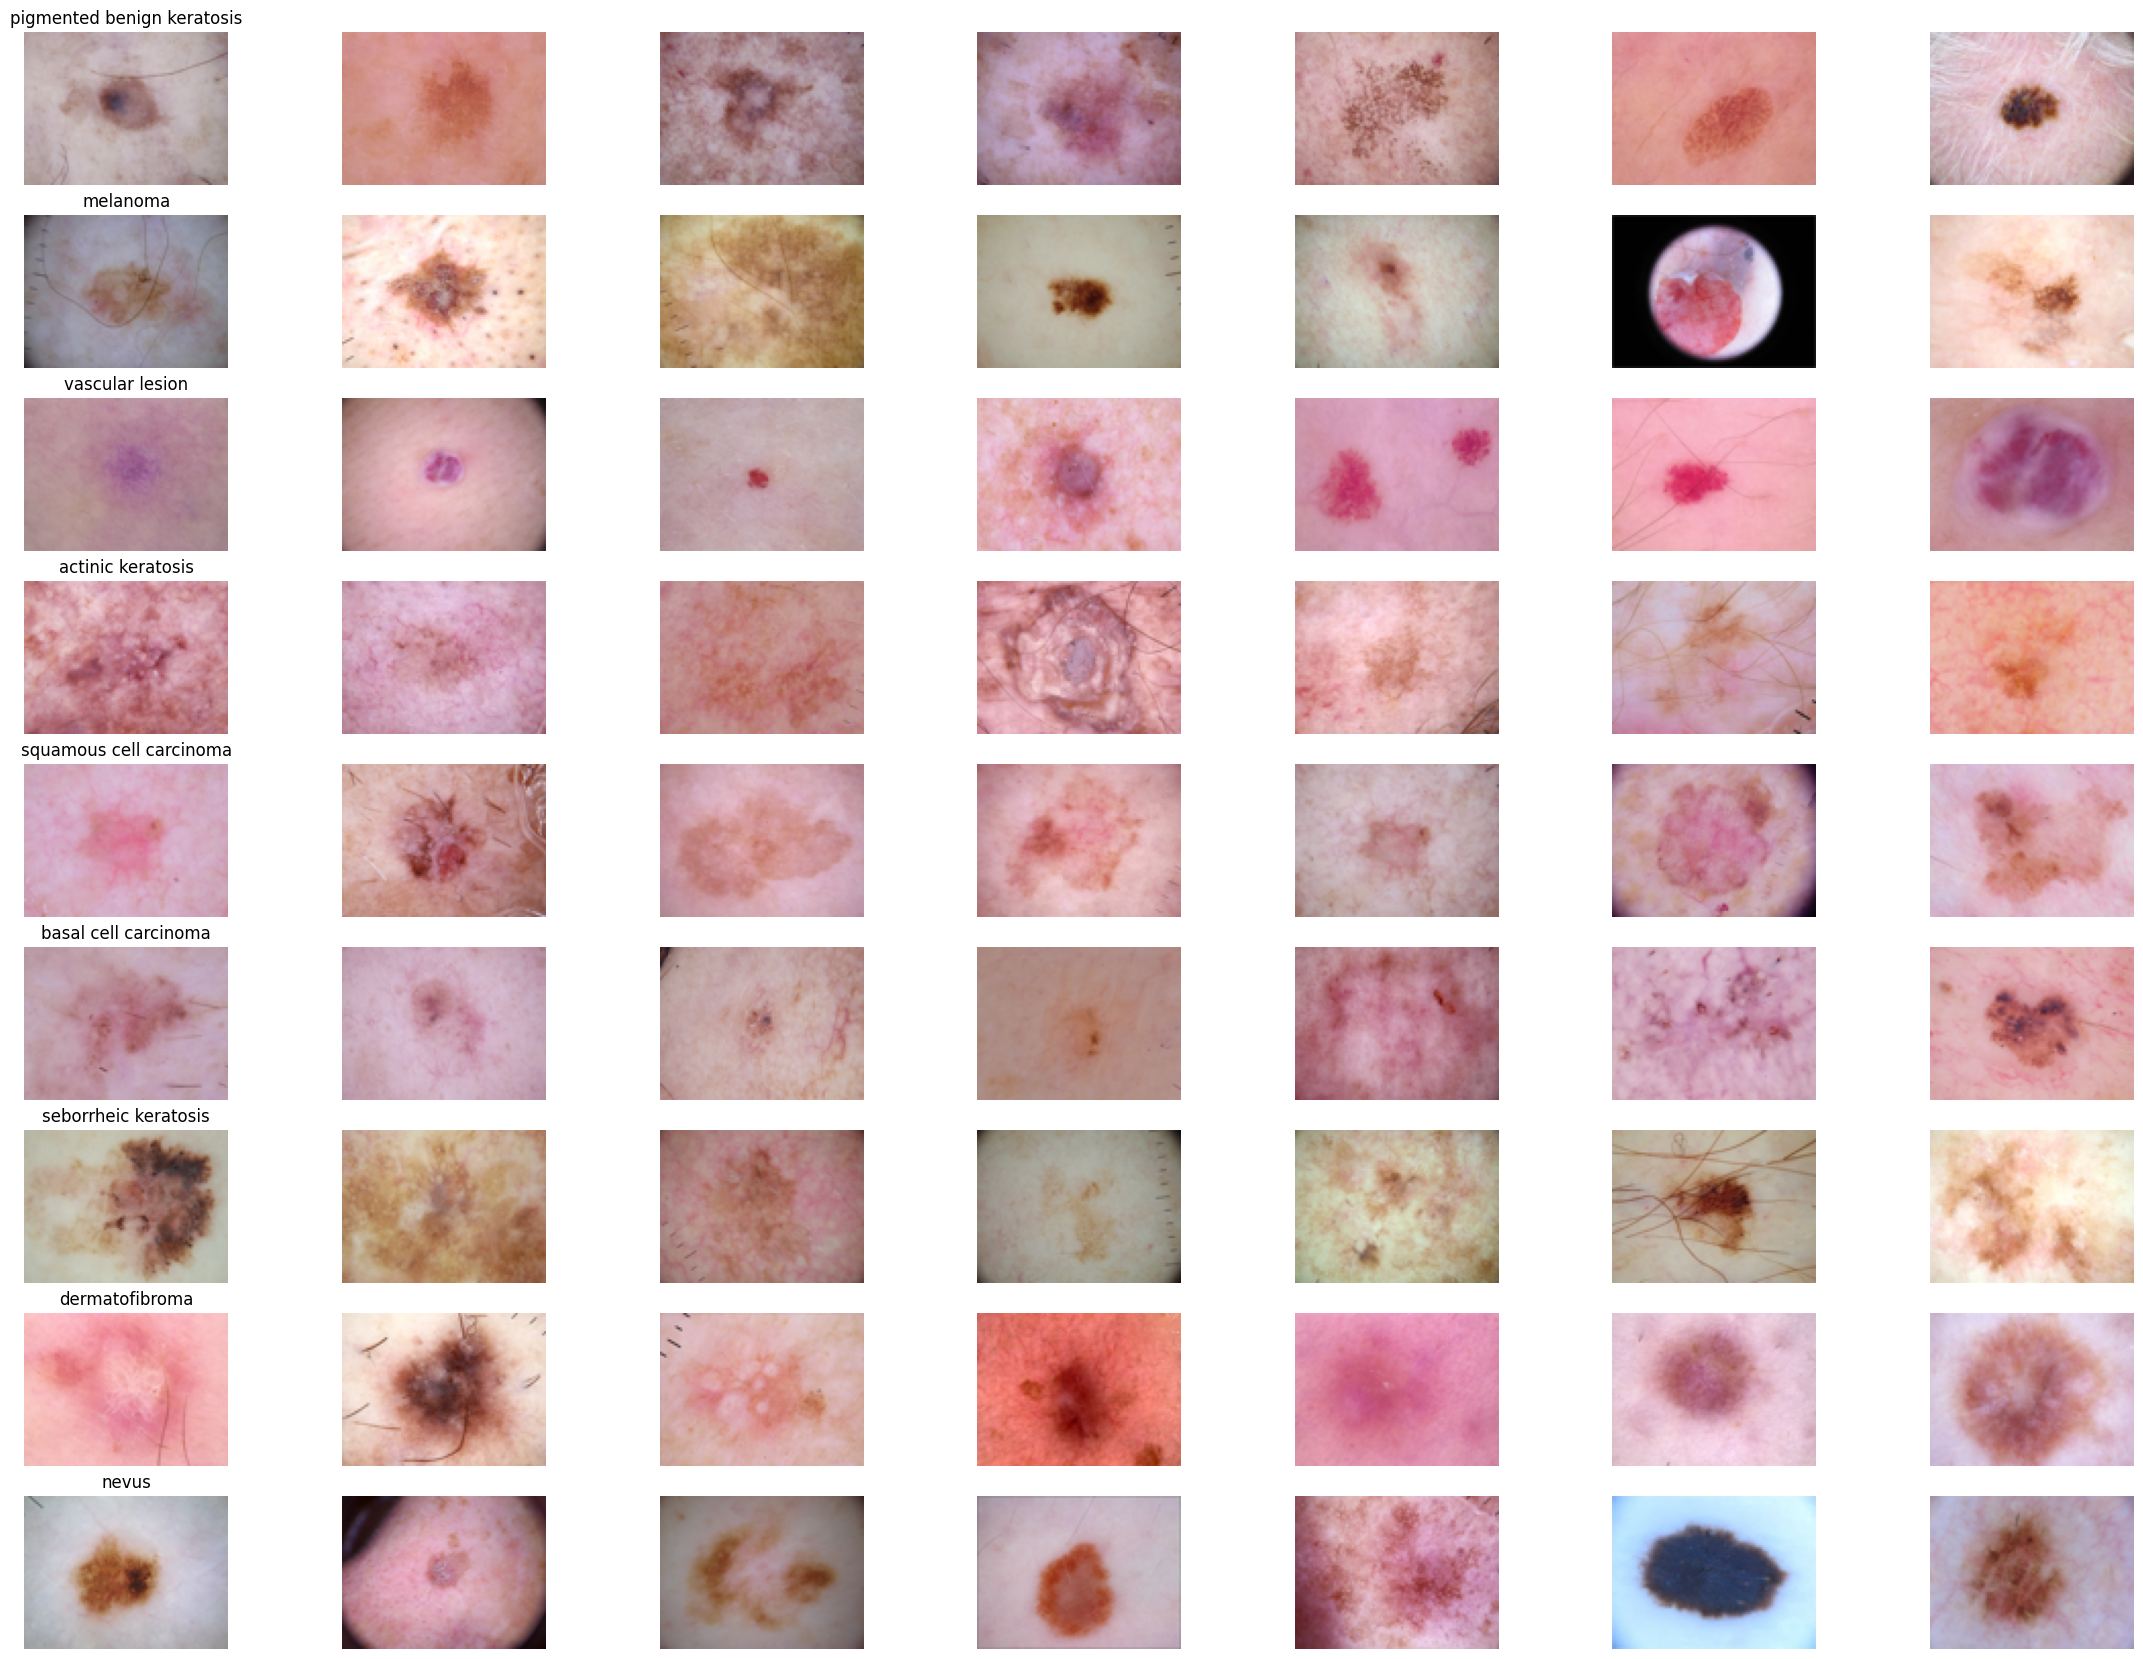

In [12]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

The images of various skin cancer

In [13]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2357
Name: count, dtype: int64

The above code is used to check how many images of different sizes are there in the dataset. For the given dataset - all the images are of same size (height,width,color_channels)

# Data Augmentatation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

This code creates an ImageDataGenerator that performs data augmentation on your training images to help reduce overfitting. It randomly applies a set of transformations each time an image is loaded: rotating up to 20°, shifting the image horizontally or vertically by up to 20%, applying shear distortions, zooming in/out by 20%, and flipping the image horizontally. When new pixel values are needed (after rotation or shifting), it fills them using the nearest pixel values (fill_mode='nearest'). These transformations artificially expand and diversify your dataset, helping the model learn more robust features and generalize better.

In [15]:
# Create an empty list to store augmented data
augmented_data = []

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate how many more images are needed
    num_images_needed = max_images_per_class - len(image_arrays)
    
    if num_images_needed > 0:
        # Randomly choose images to augment
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        for image_array in selected_images:
            # Reshape to (1, height, width, channels)
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Create iterator for augmentation
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Generate one augmented image
            for _ in range(augmented_images.n):
                augmented_image_array = next(augmented_images)[0].astype('uint8')
                augmented_data.append({
                    'image_path': None,
                    'label': class_label,
                    'image': augmented_image_array
                })
    
    # Add original images too
    for _, row in df.loc[df['label'] == class_label].iterrows():
        augmented_data.append({
            'image_path': row['image_path'],
            'label': row['label'],
            'image': row['image']
        })

# Create dataframe from all augmented data
augmented_df = pd.DataFrame(augmented_data)

df = (
    augmented_df.groupby('label')
                .head(max_images_per_class)
                .reset_index(drop=True)
)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

del augmented_df


This code balances your dataset by equalizing the number of images in each class using data augmentation. For each class, it checks how many images are missing to reach max_images_per_class and randomly selects existing images to generate new augmented versions using the previously defined ImageDataGenerator. Each selected image is expanded, passed through the augmentation pipeline, and the resulting transformed image is added to a list along with its label. Original images are also added. After all classes are processed, a new dataframe is created containing both original and augmented images, but only up to the maximum required per class. Finally, the combined dataset is shuffled to avoid ordering bias, creating a balanced dataset where each class has the same number of images.

In [16]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     2500      
1               melanoma                       2500      
2               vascular lesion                2500      
3               actinic keratosis              2500      
4               squamous cell carcinoma        2500      
5               basal cell carcinoma           2500      
6               seborrheic keratosis           2500      
7               dermatofibroma                 2500      
8               nevus                          2500      
------------------------------------------------------------
Total                                         22500     


# Training the model

In [17]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

Drop the target from  features.

In [18]:
features.head()

image
0  [[[186, 92, 107], [186, 91, 104], [186, 89, 10...
1  [[[176, 137, 135], [174, 134, 131], [172, 132,...
2  [[[208, 181, 213], [208, 181, 213], [208, 181,...
3  [[[159, 120, 117], [161, 122, 122], [162, 122,...
4  [[[159, 125, 124], [158, 124, 123], [158, 124,...

In [19]:
target.head()

0    0
1    3
2    7
3    3
4    4
Name: label, dtype: int64

In [20]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

Above code, splits the dataset into train and test.

In [22]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

This code converts your training and test image columns into NumPy arrays and then normalizes the pixel values to improve model training. First, it extracts the raw image arrays from the dataframe (`x_train[image]`) and converts them into NumPy arrays. Then it calculates the mean and standard deviation of pixel intensities separately for the training and test sets. Using these statistics, it standardizes the images: each pixel is transformed by subtracting the dataset’s mean and dividing by its standard deviation. This normalization ensures that all images have similar value ranges, helps the model train faster, and reduces the risk of overfitting by stabilizing gradients.

In [23]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [24]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [25]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [26]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [27]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               pigmented benign keratosis     1569       422          509        2500      
1               melanoma                       1602       363          535        2500      
2               vascular lesion                1579       408          513        2500      
3               actinic keratosis              1630       391          479        2500      
4               squamous cell carcinoma        1606       404          490        2500      
5               basal cell carcinoma           1586       409          505        2500      
6               seborrheic keratosis           1608       406          486        2500      
7               dermatofibroma                 1606       

In [28]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [29]:
input_shape = df['image'][0].shape

In [30]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ------------------------------------------------------------
# Create the DenseNet Model (your structure exactly)
# ------------------------------------------------------------
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze base model for Phase 1
base_model.trainable = False

inputs = base_model.input
x = Flatten()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

I0000 00:00:1764112229.448115      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 100,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 81, 106,   │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 38, 50,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 38, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 38, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 40, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 19, 25,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 19, 25,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 19, 25,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 19, 25,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 19, 25,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 19, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 19, 25,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 19, 25,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 19, 25,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 19, 25,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 19, 25,    │     12,288 │ conv2_block2_0_r

 Total params: 24,271,433 (92.59 MB)

 Trainable params: 5,926,409 (22.61 MB)

 Non-trainable params: 18,345,024 (69.98 MB)

This code builds your custom DenseNet201-based classification model exactly as you designed it. First, it loads **DenseNet201** without its top classification layers (`include_top=False`) and freezes all of its pretrained ImageNet layers so they won’t update during Phase-1 training. Then it adds your custom head: the DenseNet output is flattened, normalized using **BatchNormalization**, passed through two **Dropout** layers (0.5 and 0.6 dropout rates) to reduce overfitting, and a **Dense(512, relu)** layer to learn high-level features. Finally, a softmax output layer predicts the `num_classes` categories. The model is then assembled using `Model(inputs, outputs)` and `summary()` shows the architecture.

In [31]:
# compile model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping 
opt = Adam(learning_rate=0.001) 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# Set a learning rate annealer 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
# Add early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

This code prepares your model for training by compiling it and setting important training controls. It uses the **Adam optimizer** with a learning rate of **0.001**, making training fast and stable, and defines **categorical crossentropy** as the loss function since this is a multi-class classification problem. Two callbacks are added to improve training: **ReduceLROnPlateau**, which lowers the learning rate by half whenever the validation loss stops improving for 3 epochs, helping the model fine-tune more smoothly; and **EarlyStopping**, which stops training if validation loss doesn’t improve for 3 epochs and restores the best weights to prevent overfitting. These mechanisms together stabilize training and avoid wasting time on unproductive epochs.

In [32]:
epochs_phase1 = 15
batch_size = 16

print("--- Phase 1: Training top layers ---")
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs_phase1,
    batch_size=batch_size,
    validation_data=(x_validate, y_validate),
    callbacks=[learning_rate_reduction, early_stopping]
)

base_model.trainable = True

# Fine-tune only the top 10 DenseNet layers
for layer in base_model.layers[:-10]:
    layer.trainable = False


# Compile with lower LR
opt_fine_tune = Adam(learning_rate=0.0001)
model.compile(optimizer=opt_fine_tune, loss='categorical_crossentropy', metrics=['accuracy'])

epochs_phase2 = 10

print("\n--- Phase 2: Fine-tuning model ---")
history_fine_tune = model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs_phase1 + epochs_phase2,
    initial_epoch=history.epoch[-1],
    batch_size=batch_size,
    validation_data=(x_validate, y_validate),
    callbacks=[learning_rate_reduction, early_stopping]
)

# Combine history
for key in history.history:
    history.history[key].extend(history_fine_tune.history[key])

--- Phase 1: Training top layers ---
Epoch 1/15


I0000 00:00:1764112262.183068     113 service.cc:148] XLA service 0x7b2a1c002130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764112262.184080     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764112266.420439     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/900 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.2014 - loss: 3.3425    

I0000 00:00:1764112284.222811     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


900/900 ━━━━━━━━━━━━━━━━━━━━ 97s 61ms/step - accuracy: 0.4036 - loss: 2.6860 - val_accuracy: 0.6144 - val_loss: 1.0638 - learning_rate: 0.0010
Epoch 2/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.5385 - loss: 1.2903 - val_accuracy: 0.6356 - val_loss: 1.0008 - learning_rate: 0.0010
Epoch 3/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.5610 - loss: 1.2228 - val_accuracy: 0.6606 - val_loss: 0.9484 - learning_rate: 0.0010
Epoch 4/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.5818 - loss: 1.1539 - val_accuracy: 0.6725 - val_loss: 0.8844 - learning_rate: 0.0010
Epoch 5/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.5960 - loss: 1.1022 - val_accuracy: 0.6761 - val_loss: 0.8931 - learning_rate: 0.0010
Epoch 6/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.6083 - loss: 1.0896 - val_accuracy: 0.6958 - val_loss: 0.8416 - learning_rate: 0.0010
Epoch 7/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.6180 - loss: 1.0721

This code performs two-phase training (transfer learning + fine-tuning) for your DenseNet model. In **Phase 1**, only the custom top layers you added are trained while the DenseNet base remains frozen, using 15 epochs and a small batch size of 16. After this initial training, **Phase 2** begins by unfreezing the DenseNet base but allowing only the **top 10 layers** of DenseNet to be trainable; all lower layers stay frozen to prevent overfitting. The model is recompiled with a much lower learning rate (0.0001) to avoid damaging the pretrained weights, after which fine-tuning continues for 10 more epochs. ReduceLROnPlateau adjusts the learning rate when validation loss stalls, and EarlyStopping ends training early if overfitting begins. Finally, the histories from both phases are merged so you can plot training curves continuously.


# Performance Analysis

In [33]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
#print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

print("[INFO] accuracy: {:.2f}%".format(accuracy * 100)) 
print("[INFO] Loss: {}".format(loss)) 

450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9208 - loss: 0.2467
[INFO] accuracy: 92.05%
[INFO] Loss: 0.24532470107078552


In [34]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

print("[INFO] Testing accuracy: {:.2f}%".format(accuracy * 100)) 
print("[INFO] Testing Loss: {}".format(loss)) 

141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - accuracy: 0.8132 - loss: 0.5594
Testing: accuracy = 0.802667  ;  loss = 0.582418
[INFO] Testing accuracy: 80.27%
[INFO] Testing Loss: 0.5824181437492371


141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step


<Axes: >

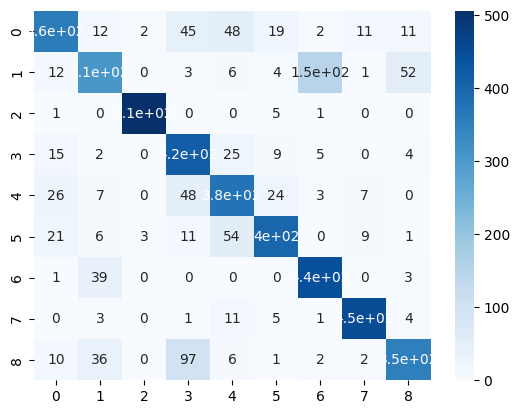

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [36]:
print(cm)

[[359  12   2  45  48  19   2  11  11]
 [ 12 306   0   3   6   4 151   1  52]
 [  1   0 506   0   0   5   1   0   0]
 [ 15   2   0 419  25   9   5   0   4]
 [ 26   7   0  48 375  24   3   7   0]
 [ 21   6   3  11  54 400   0   9   1]
 [  1  39   0   0   0   0 443   0   3]
 [  0   3   0   1  11   5   1 451   4]
 [ 10  36   0  97   6   1   2   2 353]]


This confusion matrix shows that your model performs very well on some classes but struggles with a few specific ones, revealing where misclassifications happen most often. For several classes like **vascular lesion (class 2)**, **dermatofibroma (class 7)**, and **seborrheic keratosis (class 6)** the model predicts almost all samples correctly, showing strong class separation. However, some classes are getting confused with visually similar ones. For example, **melanoma (class 1)** is often misclassified as **seborrheic keratosis (151 samples)** and **nevus (52 samples)**, which is expected because these lesions look very similar in dermoscopic images. Similarly, **pigmented benign keratosis (class 0)** and **actinic keratosis (class 3)** often get mixed with each other and with **squamous cell carcinoma (class 4)**, indicating boundary overlap in their image features. A few classes—like **nevus (class 8)**—show significant confusion with **pigmented benign keratosis (class 0)** and **actinic keratosis (class 3)**. Overall, the matrix shows strong diagonal dominance (good accuracy) but highlights a few clinically similar lesion pairs where fine-tuning or additional class-specific augmentation may help reduce confusion.


In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100)) 
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.8027
[INFO] accuracy: 80.27%
Precision: 0.8083
Recall: 0.8057
F1-score: 0.8019
Kappa score: 0.7781


Inference: Your model is performing quite well, with all major metrics around 80%, indicating that it is learning meaningful patterns and generalizing reasonably well. The performance is balanced — meaning the model is not heavily biased toward any particular class.

141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


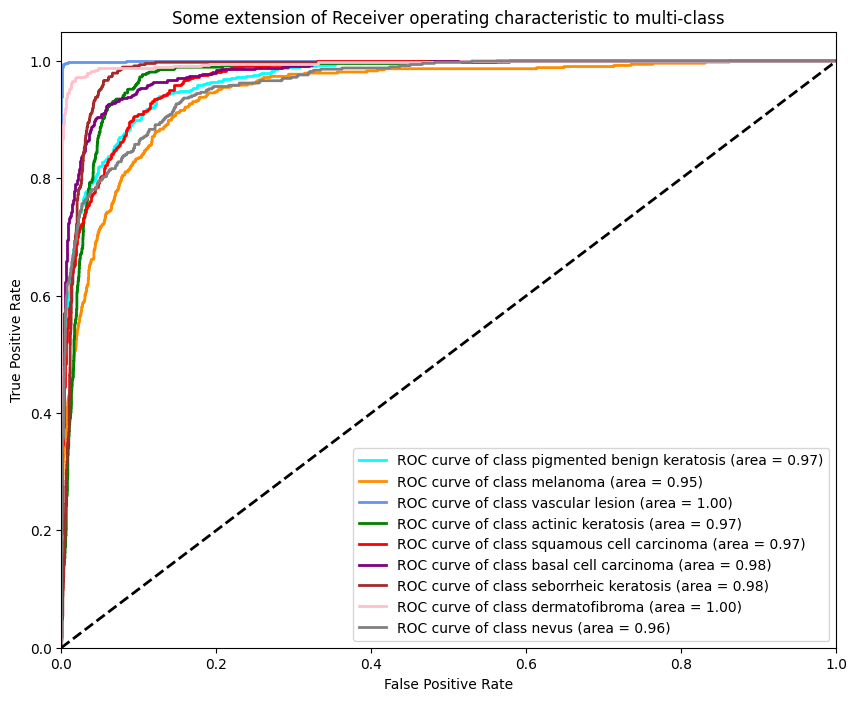

In [38]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Plotting ROC curve for each class
plt.figure(figsize=(10, 8))
n_classes = num_classes
y_score = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_map[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [39]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=[label_map[i] for i in range(num_classes)])
print(report)

                            precision    recall  f1-score   support

pigmented benign keratosis       0.81      0.71      0.75       509
                  melanoma       0.74      0.57      0.65       535
           vascular lesion       0.99      0.99      0.99       513
         actinic keratosis       0.67      0.87      0.76       479
   squamous cell carcinoma       0.71      0.77      0.74       490
      basal cell carcinoma       0.86      0.79      0.82       505
      seborrheic keratosis       0.73      0.91      0.81       486
            dermatofibroma       0.94      0.95      0.94       476
                     nevus       0.82      0.70      0.76       507

                  accuracy                           0.80      4500
                 macro avg       0.81      0.81      0.80      4500
              weighted avg       0.81      0.80      0.80      4500



This classification report shows that your model achieves **strong and balanced performance** across most of the nine skin lesion classes, with an overall accuracy of **80%**. Classes like **vascular lesion**, **dermatofibroma**, **seborrheic keratosis**, and **basal cell carcinoma** perform exceptionally well, with F1-scores between **0.81 and 0.99**, meaning the model identifies these lesions very reliably. However, a few more challenging classes show lower recall, especially **melanoma (0.57 recall)** and **pigmented benign keratosis (0.71 recall)**, indicating the model misses a noticeable number of true cases in these categories. This is common in skin lesion classification because these classes visually overlap with others. Classes like **actinic keratosis** and **squamous cell carcinoma** show good recall but slightly lower precision, meaning the model sometimes overpredicts them. The macro and weighted averages (~0.80) confirm consistent performance without major class imbalance issues. Overall, the model is strong but could still benefit from more targeted augmentation or fine-tuning specifically for melanoma and visually similar lesion classes.


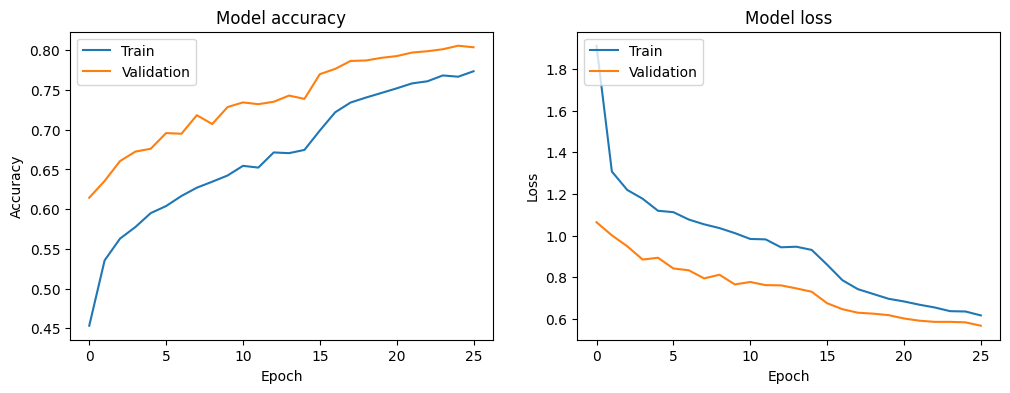

In [40]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The train and validation accuracies both increase with epochs, and loss decrease with epochs - indicating there is no major overfitting in training the model.